# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Нужно построить модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Библиотеки

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: cycler>=0.10 in c:\users\igors\anaconda3\lib\site-packages (from matplotlib->catboost) (0.11.0)



In [2]:
# импорты из стандартной библиотеки
import warnings
import os

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from statsmodels.tsa.seasonal import seasonal_decompose


from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


from sklearn.dummy import DummyRegressor

# настройки
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 87

# константы заглавными буквами
RANDOM_STATE = 0

## Подготовка данных

Считаем данные

In [3]:
path = 'C:/Users/igors/Downloads/taxi.csv'
if os.path.exists(path):
    data = pd.read_csv(path, index_col=[0], parse_dates=[0])
    display(data.head(5))
else:
    print('Ошибка в считывании данных')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Видно, что пропущенных значений нет.

### Вывод

Данные успешно считаны. Предобработка пропусков и дубликатов не требуется. Данные гоотовы к дальнейшей работе.

## Анализ 

Проверим, что у нас есть все нужные данные

In [5]:
data.sort_index(inplace=True)
if not data.index.is_monotonic:
    print('Не хватает данных')

Количество заказов в данных дано для каждых 10 минут, в задаче требуется сделать прогноз на следующий час - ресемплируем данные.

In [6]:
data = data.resample('1H').sum()
display(data.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Пострим графики количества заказов, среднего и стандартного отклонения для временного ряда и для разностей временого ряда.

<AxesSubplot:xlabel='datetime'>

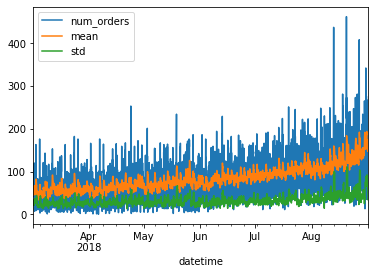

In [7]:
ts_differences = data.copy()
ts_differences['mean'] = data['num_orders'].rolling(15).mean()
ts_differences['std'] = data['num_orders'].rolling(15).std()
ts_differences = ts_differences.dropna()
ts_differences.plot()

<AxesSubplot:xlabel='datetime'>

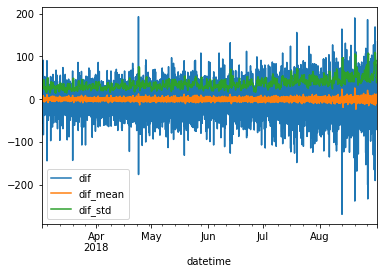

In [8]:
ts_differences['dif'] = data['num_orders'] - data['num_orders'].shift()
ts_differences['dif_mean'] = ts_differences['dif'].rolling(15).mean()
ts_differences['dif_std'] = ts_differences['dif'].rolling(15).std()
ts_differences = ts_differences.dropna()
ts_differences[['dif', 'dif_mean', 'dif_std']].plot()

Очевидно, что ряд разноостей более стационарен, поэтому для обучения могут понадобиться данные с отставанием. Также видно, что все данные имеют даты с марта по август 2018 года.

Дополнительно посмотрим на тренды, сезонность и шум.

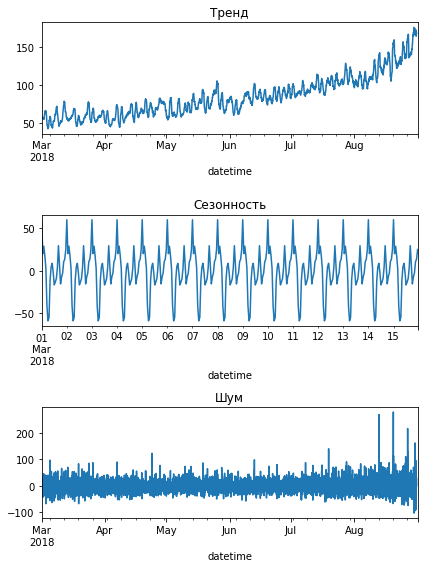

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Гафик тренда показывает, что существует тренд на увеличение колчиества заказов такси с марта по сентябрь.

График сезонности показывает, что количество заказов растёт от начала дня до конца, а потом резко падает.

Для обучения моделей будем использовать дополнительные признаки: месяц, день, день недели, отставания и скользящее среднее. Для этого напишем новую функцию.

In [10]:
def add_features(data, target_column, max_lag, rolling_mean_size):
    ext_data = data.copy()
    ext_data['month'] = ext_data.index.month
    ext_data['day'] = ext_data.index.day
    ext_data['dayofweek'] = ext_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        ext_data[f'lag_{lag}'] = ext_data[target_column].shift(lag)

    ext_data['rolling_mean'] = ext_data[target_column].shift().rolling(rolling_mean_size).mean()
    
    ext_data = ext_data.dropna()
    return ext_data

In [11]:
ext_data = add_features(data, 'num_orders', 30, 30)
display(ext_data.head())

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,11,3,2,4,11.0,20.0,64.0,75.0,120.0,90.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.133333
2018-03-02 07:00:00,7,3,2,4,11.0,11.0,20.0,64.0,75.0,120.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.366667
2018-03-02 08:00:00,46,3,2,4,7.0,11.0,11.0,20.0,64.0,75.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,51.766667
2018-03-02 09:00:00,45,3,2,4,46.0,7.0,11.0,11.0,20.0,64.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,50.933333
2018-03-02 10:00:00,54,3,2,4,45.0,46.0,7.0,11.0,11.0,20.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,50.233333


In [12]:
ext_data.shape[0]

4386

### Вывод

В ходе анализа
 - была проверена целостность данных,
 - было проведено ресемплирование данных,
 - были построены графики для временно ряда и для ряда разностей,
 - были проанализированы тренды, сезонность и шум,
 - была написана и применена функция для добавления в данные новых признаков.

## Обучение моделей

Для обучения выберем модели CatBoostRegressor, DecisionTreeRegressor и Ridge.

In [13]:
train, test = train_test_split(ext_data, shuffle=False, test_size=0.1)
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [14]:
models = [
    CatBoostRegressor(random_state=RANDOM_STATE, verbose=False), 
    DecisionTreeRegressor(random_state=RANDOM_STATE), 
    Ridge()
]

params = [
    {
        'iterations': range(10, 310, 50),
        'learning_rate': np.arange(0.1, 1, 0.1),
        'depth': range(1,11) 
    },
    {
        'max_depth': range(1,11), 
        
    },
    {
        'alpha': np.arange(0, 1, 0.01),
    }
]

Подберём оптимальные гиперпараметры с помощью GridSearchCV. Так как работаем с временным рядом, то в параметр cv передадим экземпляр TimeSeriesSplit.

In [15]:
for i in range(len(models)):
    
    model_opt = GridSearchCV(
                    estimator=models[i], 
                    param_grid=params[i],  
                    scoring='neg_root_mean_squared_error',
                    cv=TimeSeriesSplit(5),
                    n_jobs=-1
                    )
    
    model_opt = model_opt.fit(features_train, target_train)
    model_opt_best_score = model_opt.best_score_ * -1
    model_opt_best_params = model_opt.best_params_

    print()
    print(models[i],':')
    print(f'\t\tлучшее значение RMSE: {model_opt_best_score: .0f}')
    print(f'\t\tлучшие параметры: {model_opt_best_params}')


<catboost.core.CatBoostRegressor object at 0x000002886F5B9C70> :
		лучшее значение RMSE:  25
		лучшие параметры: {'depth': 8, 'iterations': 260, 'learning_rate': 0.1}

DecisionTreeRegressor(random_state=0) :
		лучшее значение RMSE:  31
		лучшие параметры: {'max_depth': 3}

Ridge() :
		лучшее значение RMSE:  27
		лучшие параметры: {'alpha': 0.01}


Все рассмотренные модели удовлетворяю условию того, что RMSE должно быть меньше 48. Из-за наименьшего значения RMSE для решения задачи рекомендуется использовать модель **CatBoostRegressor с гиперпараметрами `depth` = 7, `iterations` = 260 и `learning_rate` = 0.1**.

### Вывод

В ходе этапа 
- данные были поделены на обучающую и тестовые выборки;
- был проведён подбор гиперпараметров и анализ моделей с помощью кросс-валидации и метрики RMSE;
- была дана рекомендация использовать для решения задачи модель **CatBoostRegressor с гиперпараметрами `depth` = 8, `iterations` = 260 и `learning_rate` = 0.1**. 

## Тестирование рекомендуемой модели

Обучим рекомендуемую модель и проверим её на тестовой выборке, а также построим графики тестовых значений временного ряда и предсказанных.

In [27]:
best_model = CatBoostRegressor(random_state=RANDOM_STATE, 
                               iterations=260,
                               depth=8,
                               learning_rate=0.1,
                               verbose=False 
                               )


best_model = best_model.fit(features_train, target_train)
predict = pd.Series(best_model.predict(features_test), index=features_test.index)
mean_squared_error(predict, target_test, squared=False)

41.71483761724853

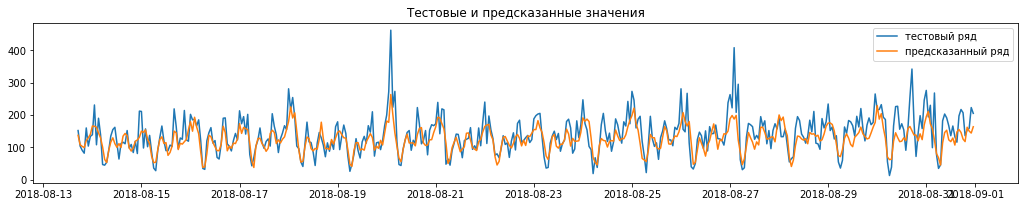

In [32]:
plt.figure(figsize=(60, 10))
plt.subplot(333)
plt.plot(target_test)
plt.plot(predict)
plt.title('Тестовые и предсказанные значения')
plt.legend(['тестовый ряд', 'предсказанный ряд'])
plt.show()

Проверим модель на адекватность. Обучим dummy-регрессор.

In [33]:
dummy = DummyRegressor()
dummy.fit(features_train, target_train)
predict = dummy.predict(features_test)
mean_squared_error(predict, target_test, squared=False)

84.69779992674266

Dummy-регрессор показывает RMSE в 2 раза больше, чем рекомендуемая модель - адекватность применения рекомендуемой модели подтверждена.

### Вывод

В ходе этапа
 - рекомендуемя модель была проверена на тестовой выборке; значение RMSE меньше 48, что соответствует поставленной задаче;
 - с помощью dummy-регрессора была обоснована адекватность применения рекомендуемой модели.

## Общий вывод

В ходе подготовки данных
 - данные успешно считаны. 
 - было установлено, что обработка пропусков не требуется. 
 
В ходе анализа данных
 - была проверена целостность данных,
 - было проведено ресемплирование данных,
 - были построены графики для временно ряда и для ряда разностей,
 - были проанализированы тренды, сезонность и шум,
 - была написана и применена функция для добавления в данные новых признаков.

В ходе обучения и аналза моделей
- данные были поделены на обучающую и тестовые выборки;
- был проведён подбор гиперпараметров и анализ моделей с помощью кросс-валидации и метрики RMSE;
- была дана рекомендация использовать для решения задачи модель **CatBoostRegressor с гиперпараметрами `depth` = 7, `iterations` = 260 и `learning_rate` = 0.1**. 

В ходе тестирования рекомендуемой модели
 - рекомендуемя модель была проверена на тестовой выборке; значение RMSE меньше 48, что соответствует поставленной задаче;
 - с помощью dummy-регрессора была обоснована адекватность применения рекомендуемой модели.